In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from talib import WMA, RSI, MACD, BBANDS
from itertools import product

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from collections import defaultdict
from sklearn.model_selection import TimeSeriesSplit
from time import time
from lightgbm import log_evaluation
from sklearn.metrics import mean_squared_error, r2_score

In [178]:
def loadPrices(fn):
    global nt, nInst
    df = pd.read_csv(fn, sep="\s+", header=None, index_col=None)
    (nt, nInst) = df.shape
    return (df.values).T


pricesFile = "./prices.txt"
prcAll = loadPrices(pricesFile)

prcHistT = pd.DataFrame(prcAll.T)

variance = prcHistT.var()
stdev = np.sqrt(variance)

In [174]:
def momentum_features(close):
    prices = close.copy()
    data = pd.DataFrame()
    lags = [1, 5, 21, 42, 63, 126, 189, 252]
    for lag in lags:
        data[f"return_{lag}d"] = (
            prices.pct_change(lag, fill_method=None)
            .stack()
        )
    for lag in [42, 63, 126, 189, 252]:  ##momentum diff indicators
        data[f"momentum_{lag//21}"] = data[f"return_{lag}d"].sub(data.return_21d)
    data[f"momentum_3_12"] = data[f"return_252d"].sub(data.return_63d)

    for t in [1, 5, 21]:  # target returns
        data[f"r{t}_fwd"] = data.groupby(level=0)[f"return_{t}d"].shift(-t)
    return data

In [175]:
def log(df):
    return np.log1p(df)


def sign(df):
    return np.sign(df)


def power(df, exp):
    return df.pow(exp)


def rank(df: pd.DataFrame) -> pd.DataFrame:
    return df.rank(axis=1, pct=True)


def scale(df: pd.DataFrame) -> pd.DataFrame:
    return df.div(df.abs().sum(axis=1), axis=0)


def lagged_ts(df: pd.DataFrame, t: int = 1) -> pd.DataFrame:
    return df.shift(t)


def diff_ts(df: pd.DataFrame, period: int = 1) -> pd.DataFrame:
    return df.diff(period)


def rollingsum_ts(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    return df.rolling(window).sum()


def rollingmean_ts(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    return df.rolling(window).mean()


def rollingweightedmean_ts(df: pd.DataFrame, period: int = 10) -> pd.DataFrame:
    return df.apply(lambda x: WMA(x, timeperiod=period))


def rollingstd_ts(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    return df.rolling(window).std()


def rollingrank_ts(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    return df.rolling(window).apply(lambda x: x.rank().iloc[-1])


def rollingproduct_ts(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    return df.rolling(window).apply(np.prod)


def rollingmin_ts(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    return df.rolling(window).min()


def rollingmax_ts(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    return df.rolling(window).max()


def maxdate_ts(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    return df.rolling(window).apply(np.argmax).add(1)


def mindate_ts(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    return df.rolling(window).apply(np.argmin).add(1)


def rollingcorr_ts(x: pd.Series, y: pd.Series, window: int = 10) -> pd.DataFrame:
    return x.rolling(window).corr(y)


def rollingcov_ts(x: pd.Series, y: pd.Series, window: int = 10) -> pd.DataFrame:
    return x.rolling(window).cov(y)

In [179]:
def alpha1(close, returns): #1
  close_copy = close.copy()
  returns = returns.shift(1)
  close_copy[returns < 0] = rollingstd_ts(returns, 20)
  return (rank(maxdate_ts(power(close_copy, 2), 5)).mul(-0.5))

def alpha2(close): #4
  return (-1* rollingrank_ts(rank(close), 9))

def alpha3(close): #9
  prices_diff = diff_ts(close, 1)
  return prices_diff.where(rollingmin_ts(prices_diff, 5) > 0, prices_diff.where(rollingmax_ts(prices_diff, 5) < 0,-prices_diff))

def alpha4(close): #10
  prices_diff = diff_ts(close, 1)
  return prices_diff.where(rollingmin_ts(prices_diff, 4) > 0, prices_diff.where(rollingmin_ts(prices_diff, 4) > 0, -prices_diff))

def alpha5(close): #23
  return diff_ts(close, 2).mul(-1).where(rollingmean_ts(close, 20) < close, 0)

def alpha6(close): #24
  cond = diff_ts(rollingmean_ts(close, 100), 100) / lagged_ts(close, 100) <= 0.05
  return close.sub(rollingmin_ts(close, 100)).mul(-1).where(cond, -diff_ts(close, 3))

def alpha7(close, returns): #29
  return rollingmin_ts(rank(rank(scale(log(rollingsum_ts(rank(rank(-rank(diff_ts((close - 1), 5)))), 2))))), 5).add(rollingrank_ts(lagged_ts((-1*returns), 6), 5))

def alpha8(close, returns): #34
  return rank(rank(rollingstd_ts(returns, 2).div(rollingstd_ts(returns, 5)).replace([-np.inf, np.inf], np.nan)).mul(-1).sub(rank(diff_ts(close, 1))).add(2))
 
def alpha9(close): #46
  cond = lagged_ts(diff_ts(close, 10), 10).div(10).sub(diff_ts(close, 10).div(10))
  alpha = pd.DataFrame(-np.ones_like(cond), index=close.index, columns=close.columns)
  alpha[cond.isnull()] = np.nan
  return cond.where(cond > 0.25, -alpha.where(cond < 0, -diff_ts(close, 1)))

def alpha10(close): #49
    cond = diff_ts(lagged_ts(close, 10), 10).div(10).sub(diff_ts(close, 10).div(10)) >= -0.1 * close
    return -diff_ts(close, 1).where(cond, 1) 


def alpha11(close): #51
  cond = diff_ts(diff_ts(close, 10), 10).div(10).sub(diff_ts(close, 10).div(10)) >= -0.05 * close
  return -diff_ts(close, 1).where(cond, 1)


In [ ]:
data = momentum_features(prcHistT)
returns = (data["return_1d"].unstack()).copy()

# Calculate all alphas
alpha1_result = alpha1(prcHistT, returns)
alpha2_result = alpha2(prcHistT)
alpha3_result = alpha3(prcHistT)
alpha4_result = alpha4(prcHistT)
alpha5_result = alpha5(prcHistT)
alpha6_result = alpha6(prcHistT)
alpha7_result = alpha7(prcHistT, returns)
alpha8_result = alpha8(prcHistT, returns)
alpha9_result = alpha9(prcHistT)
alpha10_result = alpha10(prcHistT)
alpha11_result = alpha11(prcHistT)

# Combine all alphas into a single DataFrame
all_alphas = pd.concat([
    alpha1_result, alpha2_result, alpha3_result, alpha4_result,
    alpha5_result, alpha6_result, alpha7_result, alpha8_result,
    alpha9_result, alpha10_result, alpha11_result
], axis=1, keys=['alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5', 
                 'alpha6', 'alpha7', 'alpha8', 'alpha9', 'alpha10', 'alpha11'])

# Reshape to match the MultiIndex structure
all_alphas_stacked = all_alphas.stack()

# Create MultiIndex
time_index = range(len(prcHistT))
stock_index = prcHistT.columns
multi_index = pd.MultiIndex.from_product([time_index, stock_index], names=['time', 'stock'])

# Reindex to ensure all combinations are present
all_alphas_multi = all_alphas_stacked.reindex(multi_index)

# Optionally, you can add other features from your previous DataFrame if needed
# For example, if you want to include the return features:
return_features = data[
    ["return_1d", "return_5d", "return_21d", "return_42d", "return_63d", "return_126d", "return_189d", "return_252d",
     "momentum_2", "momentum_3", "momentum_6", "momentum_9", "momentum_12", "momentum_3_12",
     "r1_fwd", "r5_fwd", "r21_fwd"
    ]
]
all_features = pd.concat([all_alphas_multi, return_features], axis=1)

# Sort the index to ensure it's in the correct order
all_features = all_features.sort_index()

In [176]:

# Calculate all alphas
alpha1_result = alpha1(prcHistT, returns)
alpha2_result = alpha2(prcHistT)
alpha3_result = alpha3(prcHistT)
alpha4_result = alpha4(prcHistT)
alpha5_result = alpha5(prcHistT)
alpha6_result = alpha6(prcHistT)
alpha7_result = alpha7(prcHistT, returns)
alpha8_result = alpha8(prcHistT, returns)
alpha9_result = alpha9(prcHistT)
alpha10_result = alpha10(prcHistT)
alpha11_result = alpha11(prcHistT)

# Combine all alphas into a single DataFrame
all_alphas = pd.concat([
    alpha1_result, alpha2_result, alpha3_result, alpha4_result,
    alpha5_result, alpha6_result, alpha7_result, alpha8_result,
    alpha9_result, alpha10_result, alpha11_result
], axis=1, keys=['alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5', 
                 'alpha6', 'alpha7', 'alpha8', 'alpha9', 'alpha10', 'alpha11'])

# Reshape to match the MultiIndex structure
all_alphas_stacked = all_alphas.stack()

# Create MultiIndex
time_index = range(len(prcHistT))
stock_index = prcHistT.columns
multi_index = pd.MultiIndex.from_product([time_index, stock_index], names=['time', 'stock'])

# Reindex to ensure all combinations are present
all_alphas_multi = all_alphas_stacked.reindex(multi_index)

# Optionally, you can add other features from your previous DataFrame if needed
# For example, if you want to include the return features:
return_features = data[
    ["return_1d", "return_5d", "return_21d", "return_42d", "return_63d", "return_126d", "return_189d", "return_252d",
     "momentum_2", "momentum_3", "momentum_6", "momentum_9", "momentum_12", "momentum_3_12",
     "r1_fwd", "r5_fwd", "r21_fwd"
    ]
]
all_features = pd.concat([all_alphas_multi, return_features], axis=1)

# Sort the index to ensure it's in the correct order
all_features = all_features.sort_index()

KeyboardInterrupt: 

In [25]:
display(all_features)

alpha1  alpha2     alpha3     alpha4  alpha5     alpha6  alpha7  \
0   0      NaN     NaN        NaN        NaN    0.00        NaN     NaN   
    1      NaN     NaN        NaN        NaN    0.00        NaN     NaN   
    2      NaN     NaN        NaN        NaN    0.00        NaN     NaN   
    3      NaN     NaN        NaN        NaN    0.00        NaN     NaN   
    4      NaN     NaN        NaN        NaN    0.00        NaN     NaN   
...        ...     ...        ...        ...     ...        ...     ...   
999 45  -0.380    -8.0   0.150000   0.150000    0.13 -44.218633    1.06   
    46  -0.090    -4.0  77.703020  77.703020    0.00  -0.001868    3.12   
    47  -0.230    -4.5  -0.000091  -0.000091    0.00  -0.001096    2.42   
    48  -0.315    -4.0  -0.000192  -0.000192    0.00  -0.000192    3.19   
    49  -0.230    -7.0 -53.133928 -53.133928   -0.12   0.240000    5.38   

        alpha8     alpha9    alpha10  ...  return_252d  momentum_2  \
0   0      NaN        NaN  -1.000000  ...          NaN         NaN   
    1      NaN        NaN  -1.000000  ...          NaN         NaN   
    2      NaN        NaN  -1.000000  ...          NaN         NaN   
    3      NaN        NaN  -1.000000  ...          NaN         NaN   
    4      NaN        NaN  -1.000000  ...          NaN         NaN   
...        ...        ...        ...  ...          ...         ...   
999 45    0.46   4.407801   0.150000  ...    -0.086552   -0.011176   
    46    0.79 -77.703020  77.703020  ...    -0.048230   -0.041379   
    47    0.82   3.425661  -0.000091  ...    -0.043429   -0.017869   
    48    0.72   4.765228  -0.000192  ...     0.273625   -0.015751   
    49    0.14  53.133928 -53.133928  ...    -0.001316    0.010240   

        momentum_3  momentum_6  momentum_9  momentum_12  momentum_3_12  \
0   0          NaN         NaN         NaN          NaN            NaN   
    1          NaN         NaN         NaN          NaN            NaN   
    2          NaN         NaN         NaN          NaN            NaN   
    3          NaN         NaN         NaN          NaN            NaN   
    4          NaN         NaN         NaN          NaN            NaN   
...            ...         ...         ...          ...            ...   
999 45   -0.016233   -0.057720   -0.061717    -0.086326      -0.070093   
    46   -0.050472   -0.057578   -0.027528    -0.047460       0.003012   
    47   -0.004248   -0.024402   -0.028976    -0.019237      -0.014990   
    48    0.011533    0.001537    0.114132     0.278693       0.267160   
    49   -0.003241   -0.010973   -0.017848    -0.009473      -0.006232   

          r1_fwd  r5_fwd  r21_fwd  
0   0        NaN     NaN      NaN  
    1        NaN     NaN      NaN  
    2        NaN     NaN      NaN  
    3        NaN     NaN      NaN  
    4        NaN     NaN      NaN  
...          ...     ...      ...  
999 45  0.003088     NaN      NaN  
    46 -0.005052     NaN      NaN  
    47 -0.008999     NaN      NaN  
    48 -0.001316     NaN      NaN  
    49       NaN     NaN      NaN  

[50000 rows x 28 columns]

In [81]:
best_params = {
    "train_length": 756.0,
    "test_length": 63.0,
    "learning_rate": 0.1,
    "num_leaves": 128.0,
    "feature_fraction": 0.6,
    "min_data_in_leaf": 250.0,
    "boost_rounds": 450.0,
}
best_params = pd.Series(best_params)

params = dict(boosting="gbdt", objective="regression", verbose=-1)

dates = sorted(all_features.index.get_level_values(0).unique())

train_dates = dates[-int(best_params["train_length"]) :]

idx = pd.IndexSlice
data = all_features.loc[idx[train_dates, :], :]

labels = sorted(data.filter(like="_fwd").columns)
features = data.columns.difference(labels).tolist()

lookahead = 1
label = f"r{lookahead}_fwd"

In [56]:
lgb_train = lgb.Dataset(
    data=data[features],
    label=data[label],
    free_raw_data=False,
)

In [57]:
train_params = ["learning_rate", "num_leaves", "feature_fraction", "min_data_in_leaf"]
params.update(best_params.loc[train_params].to_dict())
for p in ["min_data_in_leaf", "num_leaves"]:
    params[p] = int(params[p])

{'boosting': 'gbdt',
 'objective': 'regression',
 'verbose': -1,
 'learning_rate': 0.1,
 'num_leaves': 128,
 'feature_fraction': 0.6,
 'min_data_in_leaf': 250}

In [177]:
lgb_model = lgb.train(
    params=params, train_set=lgb_train, num_boost_round=int(best_params.boost_rounds)
)

In [183]:
def getMyPosition(prcSoFar):
  global currentPos
  prices = pd.DataFrame(prcSoFar.T)
  prices_copy = prices.copy()

  data = momentum_features(prices)
  returns = (data["return_1d"].unstack()).copy()

  
  alpha1_result = alpha1(prices, returns)
  alpha2_result = alpha2(prices)
  alpha3_result = alpha3(prices)
  alpha4_result = alpha4(prices)
  alpha5_result = alpha5(prices)
  alpha6_result = alpha6(prices)
  alpha7_result = alpha7(prices, returns)
  alpha8_result = alpha8(prices, returns)
  alpha9_result = alpha9(prices)
  alpha10_result = alpha10(prices)
  alpha11_result = alpha11(prices)
  # Combine all alphas into a single DataFrame

  all_alphas = pd.concat([
      alpha1_result, alpha2_result, alpha3_result, alpha4_result,
      alpha5_result, alpha6_result, alpha7_result, alpha8_result,
      alpha9_result, alpha10_result, alpha11_result
  ], axis=1, keys=['alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5', 
                  'alpha6', 'alpha7', 'alpha8', 'alpha9', 'alpha10', 'alpha11'])

  # Reshape to match the MultiIndex structure
  all_alphas_stacked = all_alphas.stack()

  # Create MultiIndex
  time_index = range(len(prices))
  stock_index = prices.columns
  multi_index = pd.MultiIndex.from_product([time_index, stock_index], names=['time', 'stock'])

  # Reindex to ensure all combinations are present
  all_alphas_multi = all_alphas_stacked.reindex(multi_index)

  # Optionally, you can add other features from your previous DataFrame if needed
  # For example, if you want to include the return features:
  return_features = data[
      ["return_1d", "return_5d", "return_21d", "return_42d", "return_63d", "return_126d", "return_189d", "return_252d",
      "momentum_2", "momentum_3", "momentum_6", "momentum_9", "momentum_12", "momentum_3_12",
      "r1_fwd", "r5_fwd", "r21_fwd"
      ]
  ]
  all_features = pd.concat([all_alphas_multi, return_features], axis=1)

  # Sort the index to ensure it's in the correct order
  all_features = all_features.sort_index()

  best_params = {
    "train_length": 756.0,
    "test_length": 63.0,
    "learning_rate": 0.1,
    "num_leaves": 128.0,
    "feature_fraction": 0.6,
    "min_data_in_leaf": 250.0,
    "boost_rounds": 450.0}
  best_params = pd.Series(best_params)

  params = dict(boosting="gbdt", objective="regression", verbose=-1)

  dates = sorted(all_features.index.get_level_values(0).unique())

  train_dates = dates[-int(best_params["train_length"]) :]

  idx = pd.IndexSlice
  data = all_features.loc[idx[train_dates, :], :]

  labels = sorted(data.filter(like="_fwd").columns)
  features = data.columns.difference(labels).tolist()
  lookahead = 1
  label = f"r{lookahead}_fwd"


  lgb_train = lgb.Dataset(
    data=data[features],
    label=data[label],
    free_raw_data=False
  )

  train_params = ["learning_rate", "num_leaves", "feature_fraction", "min_data_in_leaf"]
  params.update(best_params.loc[train_params].to_dict())
  for p in ["min_data_in_leaf", "num_leaves"]:
      params[p] = int(params[p])
  
  lgb_model = lgb.train(
    params=params, train_set=lgb_train, num_boost_round=int(best_params.boost_rounds)
  )
  
  latest_data = data.loc[data.index.get_level_values(0).max()]
  latest_features = latest_data[features]
  predicted_returns = lgb_model.predict(latest_features)

  position_limit = 10000  # Maximum absolute value of position per stock
  #volatility_threshold = 0.02  # Adjust this threshold as needed

  # Calculate positions based on predicted returns and volatility
  positions = np.zeros(nInst)
  latest_prices = prices_copy.iloc[-1, :]

  for i in range(nInst):
      #volatility = np.std(prices_copy[i, -30:]) / np.mean(prices_copy[i, -30:])  # 30-day historical volatility

      if predicted_returns[i] > 0: #and volatility < volatility_threshold:
          positions[i] = position_limit / latest_prices[i]  # 100% long position
      #elif predicted_returns[i] > 0 #and volatility >= volatility_threshold:
          #positions[i] = (position_limit / latest_prices[i]) * 0.75  # 75% long position
      elif predicted_returns[i] < 0: #and volatility < volatility_threshold:
          positions[i] = -position_limit / latest_prices[i]  # 100% short position
      #elif predicted_returns[i] < 0 #and volatility >= volatility_threshold:
          #positions[i] = -(position_limit / latest_prices[i]) * 0.75  # 75% short position

  # Update the current positions
  currentPos = np.array([int(x) for x in positions])

  # Print some statistics for verification
  print(f"Number of long positions: {np.sum(currentPos > 0)}")
  print(f"Number of short positions: {np.sum(currentPos < 0)}")
  print(f"Sum of absolute positions: {np.sum(np.abs(currentPos))}")
  print(f"Max position: {np.max(np.abs(currentPos))}")

  return currentPos


getMyPosition(prcAll)

KeyError: 999

In [ ]:
np.random.seed(42)
nInst = 50
nt = 0
commRate = 0.0010
dlrPosLimit = 10000


def simPrices(prcHist):
    n = 252
    t = 1
    tau = t / n
    prcHist = pd.DataFrame(prcHist.T)
    returns = prcHist.pct_change()

    sigma = returns.iloc[:-500, :].std()

    mean = returns.mean()
    mu = mean - (0.5 * sigma**2)
    S = prcHist.iloc[-1, :]
    simmedPrices = np.zeros((n, len(prcHist.columns)))
    simmedPrices[0, :] = S

    for i in range(1, n):
        Z = np.random.normal(0, 1)
        # Simulate log prices
        simmedPrices[i, :] = (
            simmedPrices[i - 1, :]
            + (mu * simmedPrices[i - 1, :])
            + (sigma * simmedPrices[i - 1, :] * Z)
        )

    # Convert simulated log prices back to normal prices
    simmedPrices = pd.DataFrame(simmedPrices)

    return simmedPrices


def calcPL(prcHist):
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(1001, 1251):
        prcHistSoFar = prcHist[:, :t]
        newPosOrig = getMyPosition(prcHistSoFar)
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits)
        deltaPos = newPos - curPos
        dvolumes = curPrices * np.abs(deltaPos)
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume
        comm = dvolume * commRate
        cash -= curPrices.dot(deltaPos) + comm
        curPos = np.array(newPos)
        posValue = curPos.dot(curPrices)
        todayPL = cash + posValue - value
        todayPLL.append(todayPL)
        value = cash + posValue
        ret = 0.0
        if totDVolume > 0:
            ret = value / totDVolume
        print(
            "Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf"
            % (t, value, todayPL, totDVolume, ret)
        )
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if plstd > 0:
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume, todayPLL)


simulated_prices = simPrices(prcAll).T
prcFull = pd.concat(
    [pd.DataFrame(prcAll), pd.DataFrame(simulated_prices)], axis=1, ignore_index=True
).values

(meanpl, ret, plstd, sharpe, dvol, todayPLL) = calcPL(prcFull)
score = meanpl - 0.1 * plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

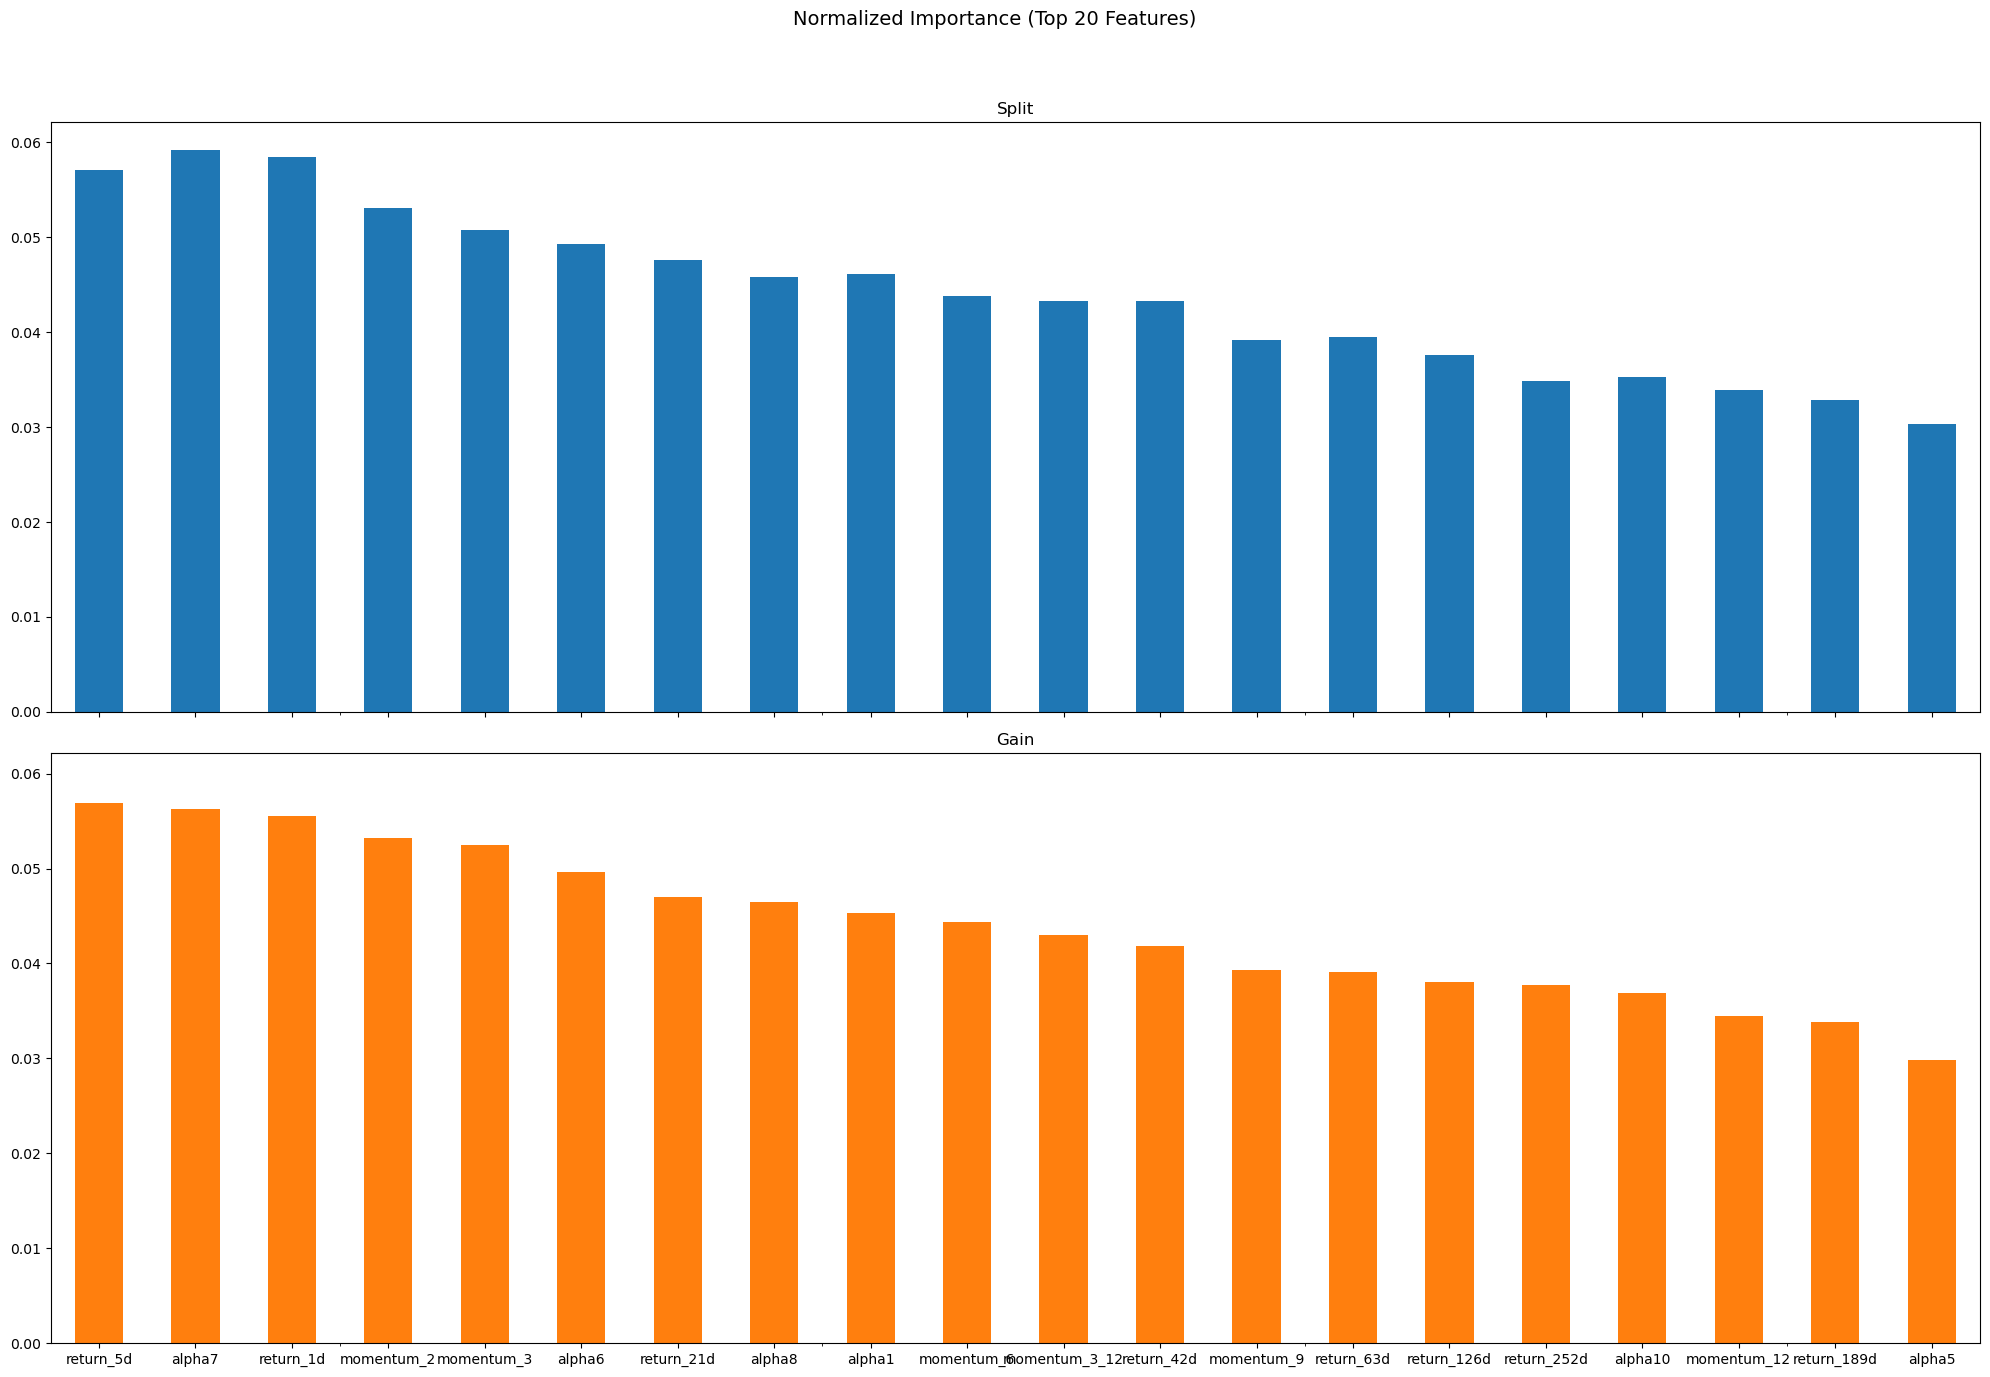

In [184]:
def get_feature_importance(model, importance_type="split"):
    fi = pd.Series(
        model.feature_importance(importance_type=importance_type),
        index=model.feature_name(),
    )
    return fi / fi.sum()


feature_importance = (
    get_feature_importance(lgb_model)
    .to_frame("Split")
    .join(get_feature_importance(lgb_model, "gain").to_frame("Gain"))
)
(
    feature_importance.nlargest(20, columns="Gain")
    .sort_values("Gain", ascending=False)
    .plot.bar(
        subplots=True, layout=(2, 1), figsize=(20, 14), legend=False, sharey=True, rot=0
    )
)
plt.suptitle("Normalized Importance (Top 20 Features)", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)